In [1]:
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
import operator

# Load environment variables from .env file
load_dotenv()

# Step2 : Create Pydantic Class to store the feedback in structured format
class evaluation_tweet_schema(BaseModel):
   evaluation_of_the_tweet: Literal ["approved", "needs_improvement"] = Field(description="Evaluation of the tweet")
   feedback: str = Field(..., description="feedback for the tweet.") 

# Step1 : Declare LLM Models each having specific tasks
generator_llm= ChatOpenAI(model = "gpt-4o",temperature=0, api_key=os.getenv("OPEN_API_KEY") )
evaluator_llm = ChatOpenAI(model = "gpt-4o-mini",temperature=0, api_key=os.getenv("OPEN_API_KEY") )
optimizer_llm= ChatOpenAI(model = "gpt-4o",temperature=0, api_key=os.getenv("OPEN_API_KEY") )

# Step3 : Create Structured Model using eithre Json Schema or Pydantic Class
structured_evaluator_llm_model = evaluator_llm.with_structured_output(evaluation_tweet_schema)


# Step2 : Define workflow state
class TweetOnTopicState(TypedDict):
    topic : str
    tweet_generated_on_the_topic : str
    evaluation_of_the_tweet: Literal ["approved", "needs_improvement"]
    optimized_tweet_on_the_topic: str
    iteration: int
    max_iteration: int
    feedback : str
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

# Step : Generate the tweet
def generate_tweet_for_the_topic(state: TweetOnTopicState):
    # creating prompt
    topic = state["topic"]
    iteration = state['iteration'] + 1
    messages=[
        SystemMessage(content="You are Funny and clever Twitter/X Influencer."),
        HumanMessage(content=f"""
                    Write a short, original, and hilarious tweet on the topic {topic}.
                    Rules
                    1. Do not use question-answer format.
                    2. Max 280 Characters.
                    3. Use Observational humor, irony, sarcasm, or cultural refernces.
                    4. Think in mem logic, punchlines, or relatable takes.
                    5. Use simple, day to day english
                    6. This is version {iteration}.
                     """)
    ]
    tweet_generated_on_the_topic = generator_llm.invoke(messages).content
    print(tweet_generated_on_the_topic)  
    return {'tweet_generated_on_the_topic': tweet_generated_on_the_topic, 'tweet_history': [tweet_generated_on_the_topic], 'iteration': iteration}

# Step : Tweet the tweet
def tweet_it(state : TweetOnTopicState):
    tweet_generated_on_the_topic = state["tweet_generated_on_the_topic"]
    return {'tweet_generated_on_the_topic': tweet_generated_on_the_topic}

# Step : Optimize the tweet
def optimize_the_tweet(state: TweetOnTopicState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
                Improve the tweet based on this feedback_history: {state['feedback_history']}
                topic: {state['topic']}
                tweet_history: {state['tweet_history']}
                Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters. Not repeating the tweets already generated. """)
                ]

    iteration = state['iteration'] + 1  
    optimized_tweet_on_the_topic = optimizer_llm.invoke(messages).content
    return{'tweet_generated_on_the_topic': optimized_tweet_on_the_topic,'optimized_tweet_on_the_topic': optimized_tweet_on_the_topic, 'iteration': iteration, 'tweet_history': [optimized_tweet_on_the_topic]}

# Step : Evaluate the tweet
def evaluate_the_tweet_for_the_topic(state: TweetOnTopicState):
    tweet_generated_on_the_topic = state["tweet_generated_on_the_topic"]
    evaluation_messages =[
            SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
            HumanMessage(content=f"""
                        Evaluate the following tweet:
                        Tweet: {tweet_generated_on_the_topic}
                        Use the criteria below to evaluate the tweet:
                        1. Originality  Is this fresh, or have you seen it a hundred times before?  
                        2. Humor : Did it genuinely make you smile, laugh, or chuckle?  
                        3. Punchiness : Is it short, sharp, and scroll-stopping?  
                        4. Virality Potential : Would people retweet or share it?  
                        5. Format : Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

                        Auto-reject if:
                        - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                        - It exceeds 280 characters
                        - It reads like a traditional setup-punchline joke
                        - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

                        ### Respond ONLY in structured format:
                        - evaluation: "approved" or "needs_improvement"  
                        - feedback: One paragraph explaining the strengths and weaknesses 
                        """)
                        ] 
    response = structured_evaluator_llm_model.invoke(evaluation_messages)
    return {'evaluation_of_the_tweet': response.evaluation_of_the_tweet, 'feedback': response.feedback , 'feedback_history' : [response.feedback]}

# Step: Conditional routing
def route_evaluation(state: TweetOnTopicState)-> Literal['approved','needs_improvement']:
    if state['evaluation_of_the_tweet'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'


# Step 8: Create StateGraph and add nodes and edges
tweet_topic_state = StateGraph(TweetOnTopicState)


# Step 9 : Add the Node
tweet_topic_state.add_node('generate_tweet_for_the_topic',generate_tweet_for_the_topic)
tweet_topic_state.add_node('evaluate_the_tweet_for_the_topic',evaluate_the_tweet_for_the_topic)
tweet_topic_state.add_node('optimize_the_tweet',optimize_the_tweet)
tweet_topic_state.add_node('tweet_it',tweet_it)


# # Step 10 : Add the Edge
# tweet_topic_state.add_edge(START, 'generate_tweet_for_the_topic')
# tweet_topic_state.add_edge('generate_tweet_for_the_topic',evaluate_the_tweet_for_the_topic )
# tweet_topic_state.add_conditional_edges('evaluate_the_tweet_for_the_topic', route_evaluation)
# tweet_topic_state.add_edge('optimize_the_tweet','evaluate_the_tweet_for_the_topic')
# tweet_topic_state.add_edge('tweet_it', END)

# Step 10 : Add the Edge
tweet_topic_state.add_edge(START, 'generate_tweet_for_the_topic')
tweet_topic_state.add_edge('generate_tweet_for_the_topic','evaluate_the_tweet_for_the_topic' )
tweet_topic_state.add_conditional_edges('evaluate_the_tweet_for_the_topic', route_evaluation, {'approved': 'tweet_it', 'needs_improvement': 'optimize_the_tweet'} )
tweet_topic_state.add_edge('optimize_the_tweet','evaluate_the_tweet_for_the_topic')
tweet_topic_state.add_edge('tweet_it', END)




In [2]:
# Step 11: Compile the workflow
workflow= tweet_topic_state.compile()









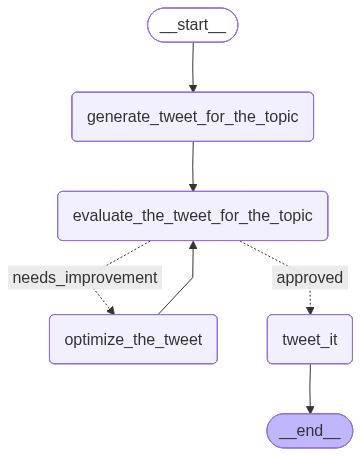

In [3]:
# Step 14: Visualize the workflow
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:

# Step 12: Define initial state
initial_state: TweetOnTopicState = {
    'topic' : 'Dhurandhar Movie',
    'tweet_generated_on_the_topic' : ' ',
    'evaluation_of_the_tweet': 'needs_improvement',
    'optimized_tweet_on_the_topic' : ' ' ,
    'iteration' : 0,
    'max_iteration': 5,
    'feedback': ' ',
    'tweet_history': [],
    'feedback_history': []

}

# Step 13: Execute the workflow with an initial state
final_state = workflow.invoke(initial_state)
print(final_state)